# Mount Google Drive



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Necessary Libraries

In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GRU, Dense, Attention, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define Path and Labels

In [ ]:
# Path to the folder containing audio files
audio_folder_path = '/content/drive/MyDrive/Colab Notebooks/folder/dataset2'

# Define labels
label_mapping = {
    'h': 'happy',
    'sa': 'sad',
    'n': 'neutral',
    'a': 'angry',
    'd': 'disgust',  # Added, but can be ignored by the condition in the code
    'f': 'fear'      # Added, but can be ignored by the condition in the code
}

# Convert labels to numeric values
label_mapping_numeric = {'happy': 0, 'sad': 1, 'neutral': 2, 'angry': 3}

# Audio Augmentation Function

In [ ]:
# Function to load and process audio files
def augment_audio(y, sr):
    # Time stretching
    y_stretch = librosa.effects.time_stretch(y, rate=0.9)

    # Pitch shifting
    y_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

    # Adding noise
    noise = np.random.randn(len(y))
    y_noise = y + 0.005 * noise

    return [y, y_stretch, y_shift, y_noise]

# Process and Augment Audio Files

In [ ]:
def process_and_augment_audio_files_with_labels(folder_path):
    audio_features = []
    audio_labels = []

    # List audio files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):  # Check file extension
            file_path = os.path.join(folder_path, file_name)
            if file_name.startswith('sa'):  # Check if the file corresponds to 'sad'
                file_label_prefix = 'sa'
            else:
                file_label_prefix = file_name[0]  # Get the first character of the file name

            if file_label_prefix not in label_mapping:
                continue  # Skip files with invalid labels

            file_label = label_mapping[file_label_prefix]

            # Keep only "happy", "sad", "neutral", and "angry" labels
            if file_label not in ['happy', 'sad', 'neutral', 'angry']:
                continue  # Skip files with other labels

            # Load audio file
            y, sr = librosa.load(file_path, sr=None)

            # Data augmentation
            augmented_audios = augment_audio(y, sr)

            for y_aug in augmented_audios:
                # Extract Log-Mel Spectrogram features
                mel_spectrogram = librosa.feature.melspectrogram(y=y_aug, sr=sr, n_mels=128, fmax=8000)
                log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
                log_mel_spectrogram_resized = np.resize(log_mel_spectrogram, (128, 128))  # Resize to 128x128

                audio_features.append(log_mel_spectrogram_resized)
                audio_labels.append(file_label)

    return np.array(audio_features), np.array(audio_labels)

# Process Audio Files and Labels

In [ ]:
# Process audio files and labels
audio_features, audio_labels = process_and_augment_audio_files_with_labels(audio_folder_path)

# Convert labels to numeric values
numeric_labels = np.array([label_mapping_numeric[label] for label in audio_labels if label in label_mapping_numeric])

# Define implicit features
def create_implicit_features(labels):
    A = np.array([1 if label in [0, 3] else 0 for label in labels])  # happy or angry
    B = np.array([1 if label == 1 else 0 for label in labels])       # sad
    C = np.array([1 if label in [1, 3] else 0 for label in labels])  # sad or angry
    D = np.array([1 if label == 0 else 0 for label in labels])       # happy
    return A, B, C, D

A, B, C, D = create_implicit_features(numeric_labels)

# Print the shape of features and labels for verification
print("Shape of audio_features:", audio_features.shape)
print("Shape of numeric_labels:", numeric_labels.shape)
print("Shape of implicit features A, B, C, D:", A.shape, B.shape, C.shape, D.shape)

Shape of audio_features: (1988, 128, 128)
Shape of numeric_labels: (1988,)
Shape of implicit features A, B, C, D: (1988,) (1988,) (1988,) (1988,)


# Define and Build the Model

In [ ]:
# Define the input layer with larger dimensions
input_layer = Input(shape=(128, 128, 1))

# CNN layers with padding
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
batch_norm1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D((2, 2))(batch_norm1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
batch_norm2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D((2, 2))(batch_norm2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
batch_norm3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D((2, 2))(batch_norm3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
batch_norm4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D((2, 2))(batch_norm4)

# Reshape for GRU input
flatten = Flatten()(pool4)

# GRU layer
gru = GRU(128, return_sequences=True)(tf.expand_dims(flatten, axis=1))

# Attention layer
attention = Attention()([gru, gru])
attention = Flatten()(attention)

# Fully Connected (FC) layers for each task
fc_shared = Dense(64, activation='relu')(attention)
dropout_shared = Dropout(0.5)(fc_shared)

# Output layers for emotion classification and implicit features
emotion_output = Dense(4, activation='softmax', name='emotion')(dropout_shared)
A_output = Dense(1, activation='sigmoid', name='A')(dropout_shared)
B_output = Dense(1, activation='sigmoid', name='B')(dropout_shared)
C_output = Dense(1, activation='sigmoid', name='C')(dropout_shared)
D_output = Dense(1, activation='sigmoid', name='D')(dropout_shared)

# Build the model
model = Model(inputs=input_layer, outputs=[emotion_output, A_output, B_output, C_output, D_output])

# Compile the model with multiple losses
model.compile(optimizer='adam',
              loss={'emotion': 'sparse_categorical_crossentropy', 'A': 'binary_crossentropy', 'B': 'binary_crossentropy', 'C': 'binary_crossentropy', 'D': 'binary_crossentropy'},
              metrics={'emotion': 'accuracy', 'A': 'accuracy', 'B': 'accuracy', 'C': 'accuracy', 'D': 'accuracy'})

# Display model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 128, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 128, 128, 64)         256       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 64)           0         ['batch_normalization_4[

# Prepare Data and Train the Model with Early Stopping

In [ ]:
# Expand dimensions of audio features
audio_features_expanded = np.expand_dims(audio_features, axis=-1)
audio_features_resized = tf.image.resize(audio_features_expanded, [128, 128]).numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(audio_features_resized, numeric_labels, test_size=0.2, random_state=42)
A_train, A_test = train_test_split(A, test_size=0.2, random_state=42)
B_train, B_test = train_test_split(B, test_size=0.2, random_state=42)
C_train, C_test = train_test_split(C, test_size=0.2, random_state=42)
D_train, D_test = train_test_split(D, test_size=0.2, random_state=42)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train,
                    {'emotion': y_train, 'A': A_train, 'B': B_train, 'C': C_train, 'D': D_train},
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, {'emotion': y_test, 'A': A_test, 'B': B_test, 'C': C_test, 'D': D_test}),
                    callbacks=[early_stopping])

Epoch 1/50
50/50 [==============================] - 146s 3s/step - loss: 3.8411 - emotion_loss: 1.3840 - A_loss: 0.6200 - B_loss: 0.5394 - C_loss: 0.7177 - D_loss: 0.5799 - emotion_accuracy: 0.3283 - A_accuracy: 0.6736 - B_accuracy: 0.7591 - C_accuracy: 0.5484 - D_accuracy: 0.7164 - val_loss: 3.9949 - val_emotion_loss: 1.4798 - val_A_loss: 0.6968 - val_B_loss: 0.5626 - val_C_loss: 0.6954 - val_D_loss: 0.5602 - val_emotion_accuracy: 0.2387 - val_A_accuracy: 0.5126 - val_B_accuracy: 0.7663 - val_C_accuracy: 0.4925 - val_D_accuracy: 0.7613
Epoch 2/50
50/50 [==============================] - 142s 3s/step - loss: 3.1482 - emotion_loss: 1.1006 - A_loss: 0.3913 - B_loss: 0.4583 - C_loss: 0.7014 - D_loss: 0.4966 - emotion_accuracy: 0.4654 - A_accuracy: 0.8635 - B_accuracy: 0.7780 - C_accuracy: 0.5509 - D_accuracy: 0.7428 - val_loss: 4.2982 - val_emotion_loss: 1.5681 - val_A_loss: 0.8743 - val_B_loss: 0.5370 - val_C_loss: 0.7052 - val_D_loss: 0.6136 - val_emotion_accuracy: 0.2462 - val_A_accura

# Evaluate the Model

13/13 [==============================] - 9s 695ms/step - loss: 1.8171 - emotion_loss: 0.6270 - A_loss: 0.1247 - B_loss: 0.1973 - C_loss: 0.4949 - D_loss: 0.3732 - emotion_accuracy: 0.6960 - A_accuracy: 0.9447 - B_accuracy: 0.9322 - C_accuracy: 0.7312 - D_accuracy: 0.7940
Emotion Classification Accuracy: 69.60%
Feature A Accuracy: 94.47%
Feature B Accuracy: 93.22%
Feature C Accuracy: 73.12%
Feature D Accuracy: 79.40%
13/13 [==============================] - 8s 603ms/step


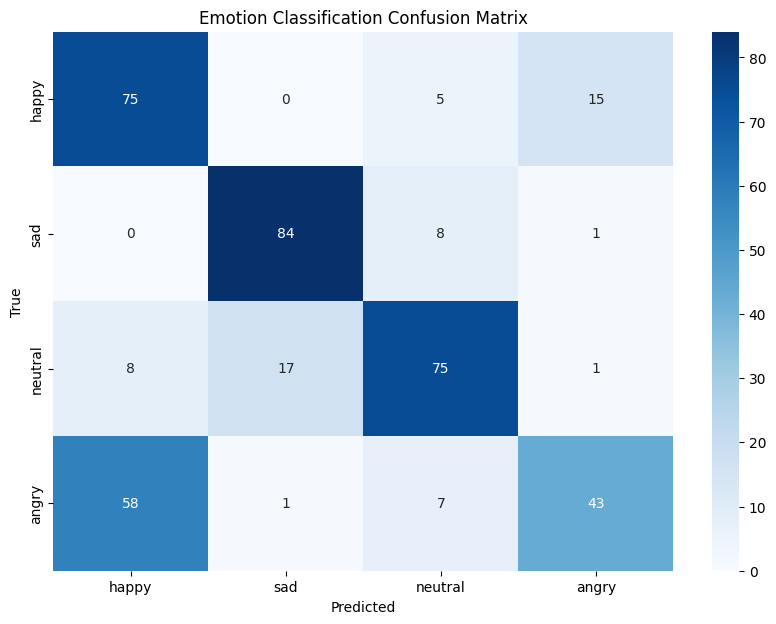

Emotion Classification Report:
               precision    recall  f1-score   support

       happy       0.53      0.79      0.64        95
         sad       0.82      0.90      0.86        93
     neutral       0.79      0.74      0.77       101
       angry       0.72      0.39      0.51       109

    accuracy                           0.70       398
   macro avg       0.72      0.71      0.69       398
weighted avg       0.72      0.70      0.69       398



In [ ]:
# Evaluate the model
evaluation_results = model.evaluate(X_test, {'emotion': y_test, 'A': A_test, 'B': B_test, 'C': C_test, 'D': D_test})

# Extract individual accuracies from evaluation results
emotion_accuracy = evaluation_results[6]  # 7th value corresponds to emotion_accuracy
A_accuracy = evaluation_results[7]        # 8th value corresponds to A_accuracy
B_accuracy = evaluation_results[8]        # 9th value corresponds to B_accuracy
C_accuracy = evaluation_results[9]        # 10th value corresponds to C_accuracy
D_accuracy = evaluation_results[10]       # 11th value corresponds to D_accuracy

# Print accuracy for each task
print(f'Emotion Classification Accuracy: {emotion_accuracy * 100:.2f}%')
print(f'Feature A Accuracy: {A_accuracy * 100:.2f}%')
print(f'Feature B Accuracy: {B_accuracy * 100:.2f}%')
print(f'Feature C Accuracy: {C_accuracy * 100:.2f}%')
print(f'Feature D Accuracy: {D_accuracy * 100:.2f}%')

# Predictions for emotion classification
emotion_pred = model.predict(X_test)[0]
emotion_pred_classes = np.argmax(emotion_pred, axis=1)

# Confusion matrix for emotion classification
conf_matrix = confusion_matrix(y_test, emotion_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping_numeric.keys(), yticklabels=label_mapping_numeric.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Emotion Classification Confusion Matrix')
plt.show()

# Classification report for emotion classification
class_report = classification_report(y_test, emotion_pred_classes, labels=list(label_mapping_numeric.values()), target_names=label_mapping_numeric.keys())
print('Emotion Classification Report:\n', class_report)


# Plot Training History

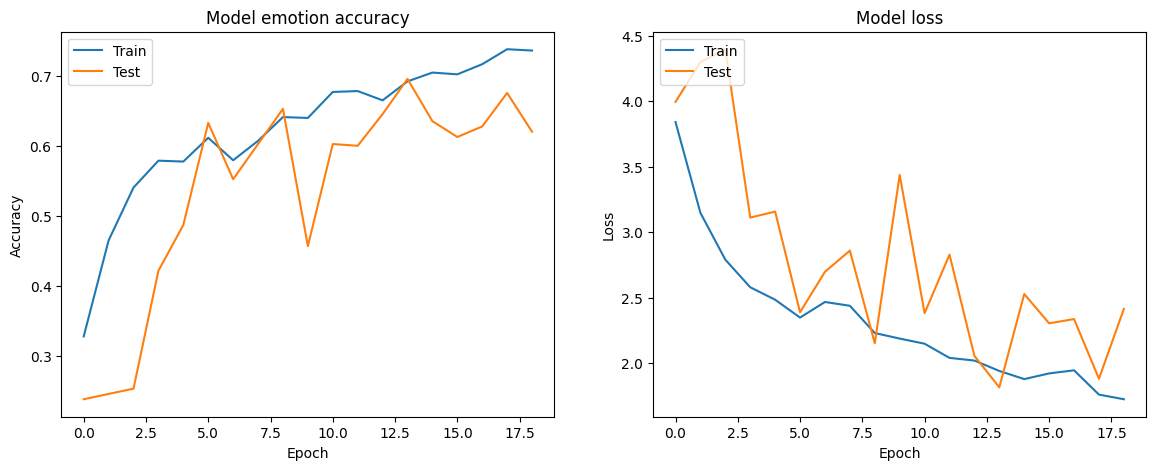

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['emotion_accuracy'])
plt.plot(history.history['val_emotion_accuracy'])
plt.title('Model emotion accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()